# THIS JOURNAL: Protein level features
1. Protein-level characterisics
    * Molecular weight
    * Isoelectric Point
    * Melting Temp
    * Aromaticity
    * Instability Index
    * Molecular Extinction Coefficient
    * Secondary Structure Fraction
    
# Features left to feature-ize
### Amino Acid-level features
1. Amino Acid Modifications
2. Secondary Structure
3. Amino Acid Disorder

### Protein-level features
1. Protein overall disorder

In [152]:
import sqlite3
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import sklearn
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import math

In [2]:
conn = sqlite3.connect("protein_training.db")
proteins_to_work_on = pd.read_sql('SELECT DISTINCT protein from protein_ngram',con=conn)
conn.close()

In [3]:
proteins_to_work_on.head()

,protein
0,RL37A_HUMAN
1,PYRG1_HUMAN
2,RL6_HUMAN
3,RAB10_HUMAN
4,RAB30_HUMAN


In [4]:
conn = sqlite3.connect("human_protein.db")
sequences = pd.read_sql('SELECT DISTINCT protein, sequence from protein',con=conn)
conn.close()

In [6]:
sequences.head()

,protein,sequence
0,RL37A_HUMAN,MAKRTKKVGIVGKYGTRYGASLRKMVKKIEISQHAKYTCSFCGKTK...
1,PYRG1_HUMAN,MKYILVTGGVISGIGKGIIASSVGTILKSCGLHVTSIKIDPYINID...
2,RL6_HUMAN,MAGEKVEKPDTKEKKPEAKKVDAGGKVKKGNLKAKKPKKGKPHCSR...
3,RAB10_HUMAN,MAKKTYDLLFKLLLIGDSGVGKTCVLFRFSDDAFNTTFISTIGIDF...
4,RAB30_HUMAN,MSMEDYDFLFKIVLIGNAGVGKTCLVRRFTQGLFPPGQGATIGVDF...


In [13]:
proteins_merge = proteins_to_work_on.merge(sequences, on='protein',how='outer')
proteins_merge[proteins_merge.isna().any(axis=1)].shape[0]==0

True

Now that we have every sequence, lets get the protein level features!

In [18]:
analysis_results = proteins_merge.sequence.apply(ProteinAnalysis)

In [97]:
# Counts, then percs
amino_acids = ['R','H','K','D','E','S','T','N','Q','C','U','G',
               'P','A','V','I','L','M','F','Y','W']
count_cols = [x+'_num' for x in amino_acids]
perc_cols = [x+'_perc' for x in amino_acids]

prot_feat_cols = count_cols + perc_cols + [
    "mol_weight","arom","insta","flex","gravy","isoel",
    "helix_perc","turn_perc","sheet_perc",
    "reduced_cys_num","disulfide_num"]

In [103]:
def proteinFeatureArrayizer(seq):
    object_ = ProteinAnalysis(seq)
    object_no_u = ProteinAnalysis(seq.replace("U","C"))
    count_dict = object_.count_amino_acids()
    perc_dict = object_.get_amino_acids_percent()
    percs = []
    counts = []
    for aa in amino_acids:
        percs.append(perc_dict.get(aa, 0))
        counts.append(count_dict.get(aa, 0))
    feat_array = percs + counts
    # Mol Weight
    mol_weight = object_.molecular_weight()
    # Aromaticiy
    arom = object_.aromaticity()
    # Instability index
    try:
        insta_in = object_.instability_index()
    except:
        insta_in = object_no_u.instability_index()
    # Flexibility
    try:
        flex = object_.flexibility()
    except:
        flex = object_no_u.flexibility()
    # Gravy
    try:
        gravy_ = object_.gravy()
    except:
        gravy_ = object_no_u.gravy()
    # Isoelectric point
    try:
        iso_el = object_.isoelectric_point()
    except:
        iso_el = object_no_u.gravy()
    # Helix percentage
    sec_stru = object_.secondary_structure_fraction()
    hel_perc = sec_stru[0]
    # Turn Percentage
    turn_perc = sec_stru[1]
    # Sheet Percentage
    sheet_perc = sec_stru[2]
    # Reduced Cys Num
    mol_extinc_coeff = object_.molar_extinction_coefficient()
    red_cys = mol_extinc_coeff[0]
    # Disulfide Bridge Num
    oxi_cys = mol_extinc_coeff[1]
    feat_array.extend([
        mol_weight, arom, insta_in, flex, gravy_, iso_el, hel_perc, 
         sheet_perc, turn_perc, red_cys, oxi_cys]
    )
    return feat_array

In [104]:
feat_array_all = proteins_merge.sequence.apply(proteinFeatureArrayizer).values.tolist()

In [105]:
feat_df = pd.DataFrame(feat_array_all, columns=prot_feat_cols)

In [106]:
feat_df.head()

,R_num,H_num,K_num,D_num,E_num,S_num,T_num,N_num,Q_num,C_num,...,arom,insta,flex,gravy,isoel,helix_perc,turn_perc,sheet_perc,reduced_cys_num,disulfide_num
0,0.076087,0.021739,0.163043,0.010870,0.021739,0.065217,0.097826,0.010870,0.021739,0.043478,...,0.076087,38.381522,"[1.0528452380952382, 1.0343333333333335, 0.991...",-0.445652,10.441467,0.239130,0.184783,0.173913,16960,17210
1,0.055838,0.030457,0.060914,0.057530,0.076142,0.069374,0.043993,0.028765,0.042301,0.020305,...,0.082910,40.825381,"[0.9663452380952381, 0.9821428571428571, 0.977...",-0.306430,6.023254,0.323181,0.225042,0.231810,62800,63550
2,0.076389,0.027778,0.180556,0.031250,0.045139,0.048611,0.055556,0.020833,0.031250,0.003472,...,0.059028,29.306250,"[1.0128214285714288, 1.080714285714286, 1.0573...",-0.731944,10.585266,0.277778,0.197917,0.201389,14900,14900
3,0.045000,0.015000,0.105000,0.070000,0.065000,0.055000,0.075000,0.050000,0.020000,0.020000,...,0.090000,29.375500,"[0.9993809523809525, 1.025690476190476, 0.9696...",-0.330000,8.583435,0.305000,0.215000,0.205000,22460,22710
4,0.059113,0.000000,0.049261,0.044335,0.093596,0.073892,0.059113,0.054187,0.049261,0.029557,...,0.098522,51.406404,"[0.9837857142857144, 1.023797619047619, 0.9633...",-0.235961,4.911560,0.325123,0.266010,0.211823,22920,23295


Expand the flexibility metric into n-sections. So-as to get a rough idea of flexibility over n-sections of the protein.

In [289]:
def backfill(size, flex_array):
    flex_arr_size = len(flex_array)
    if size % flex_arr_size == 0 and flex_arr_size!=1:
        sizer = size / flex_arr_size
        return list(np.concatenate([list(np.repeat(x, sizer)) for x in flex_array]))
    elif flex_arr_size == 1:
        return list(np.repeat(flex_array[0], size))
    # If the size of the array fits into the bigger num
    else:
        counter_arr = list(np.repeat(0, flex_arr_size))
        counter = 0
        for i in range(size):
            if counter >= flex_arr_size:
                counter = 0
            counter_arr[counter] += 1
            counter += 1
        return_arr = []
        for i, repeat in enumerate(counter_arr):
            return_arr.extend(list(np.repeat(flex_array[i], repeat)))
        return return_arr
    
def chunks(arr, n):
    for i in range(0, len(arr), n):
        n_arr = arr[i:i + n]
        yield [n_arr[0],n_arr[-1]]
    
def getFlexVals(size, flex_array):
    """Given size, return N-mean, median and range.
    If the array is less than the size, backfill the array."""
    flex_arr_size = len(flex_array)
    if flex_arr_size==0:
        return list(np.full(size*3, 0))
    if flex_arr_size < size:
        flex_arr = backfill(size, flex_array)
        #print(flex_arr_size,flex_arr)
    # Get the chunk size
    chunk_size = math.ceil(flex_arr_size / size)
    # Get the chunk indexes
    chunks_arr = list(chunks(list(range(flex_arr_size)), chunk_size))
    # Get the chunked values
    chunked_flex = [flex_array[x[0]:x[1]+1] for x in chunks_arr]

    return_flex = []
    for chunk_ in chunked_flex:
        return_flex.extend(
            [np.mean(chunk_), np.median(chunk_), np.max(chunk_)-np.min(chunk_)]
        )
    
    return return_flex

def makeFlexCols(n):
    """Flexibility of the protein is interesting to model. The metric
    is calculated using windows of 9 amino acids over the whole protein.
    Similar to n-grams.
    
    For each n-flexibility entrants, I will calculate mean, median and
    range.
    
    This function produces the column names for this."""
    col_list = []
    
    for i in range(1,n+1):
        col_list.extend([
            'flex_mean_'+str(i), 'flex_median_'+str(i), 'flex_range_'+str(i)
        ])
    return col_list

In [290]:
n= 10
flex_cols = makeFlexCols(n)

flex_processed = feat_df.iloc[:,:].flex.apply(lambda x: getFlexVals(n, x)).values.tolist()#.to_frame()

In [299]:
flex_processed_df = pd.DataFrame(flex_processed,columns=flex_cols)
flex_processed_df.head()

,flex_mean_1,flex_median_1,flex_range_1,flex_mean_2,flex_median_2,flex_range_2,flex_mean_3,flex_median_3,flex_range_3,flex_mean_4,...,flex_range_7,flex_mean_8,flex_median_8,flex_range_8,flex_mean_9,flex_median_9,flex_range_9,flex_mean_10,flex_median_10,flex_range_10
0,1.008169,1.009131,0.081560,0.999685,1.002452,0.037476,1.016550,1.023369,0.064107,0.988934,...,0.062321,0.987525,0.983726,0.040536,0.998399,0.990869,0.045560,1.032863,1.032863,0.016655
1,0.993341,0.988726,0.078881,1.003937,1.004607,0.114631,0.994951,0.990786,0.112952,1.009353,...,0.100060,1.007784,1.009131,0.086429,1.003565,1.002714,0.111845,1.007482,1.006821,0.102762
2,1.051111,1.049244,0.080631,1.015385,1.006119,0.126155,1.030064,1.021327,0.102905,1.010614,...,0.075167,1.019604,1.021405,0.084369,1.027100,1.024107,0.083238,0.991721,0.988464,0.091595
3,0.989401,0.989833,0.097679,0.985086,0.983030,0.075940,1.009335,1.009280,0.091619,0.988626,...,0.085345,1.000924,0.994690,0.083452,1.022086,1.023952,0.098810,1.011547,1.014345,0.061810
4,0.984233,0.982577,0.093536,0.992445,0.994190,0.065679,1.002848,0.993970,0.108429,0.998974,...,0.062095,1.014127,1.016768,0.086548,0.993532,0.995887,0.079179,1.010060,1.024060,0.117869


In [300]:
sequence_feat_df = pd.concat([proteins_merge.drop('sequence',axis=1),feat_df],axis=1)
sequence_feat_flex_df = pd.concat([sequence_feat_df.drop('flex',axis=1), flex_processed_df],axis=1)
sequence_feat_flex_df.set_index('protein',inplace=True)
sequence_feat_flex_df.head()

,R_num,H_num,K_num,D_num,E_num,S_num,T_num,N_num,Q_num,C_num,...,flex_range_7,flex_mean_8,flex_median_8,flex_range_8,flex_mean_9,flex_median_9,flex_range_9,flex_mean_10,flex_median_10,flex_range_10
protein,,,,,,,,,,,,,,,,,,,,,
RL37A_HUMAN,0.076087,0.021739,0.163043,0.010870,0.021739,0.065217,0.097826,0.010870,0.021739,0.043478,...,0.062321,0.987525,0.983726,0.040536,0.998399,0.990869,0.045560,1.032863,1.032863,0.016655
PYRG1_HUMAN,0.055838,0.030457,0.060914,0.057530,0.076142,0.069374,0.043993,0.028765,0.042301,0.020305,...,0.100060,1.007784,1.009131,0.086429,1.003565,1.002714,0.111845,1.007482,1.006821,0.102762
RL6_HUMAN,0.076389,0.027778,0.180556,0.031250,0.045139,0.048611,0.055556,0.020833,0.031250,0.003472,...,0.075167,1.019604,1.021405,0.084369,1.027100,1.024107,0.083238,0.991721,0.988464,0.091595
RAB10_HUMAN,0.045000,0.015000,0.105000,0.070000,0.065000,0.055000,0.075000,0.050000,0.020000,0.020000,...,0.085345,1.000924,0.994690,0.083452,1.022086,1.023952,0.098810,1.011547,1.014345,0.061810
RAB30_HUMAN,0.059113,0.000000,0.049261,0.044335,0.093596,0.073892,0.059113,0.054187,0.049261,0.029557,...,0.062095,1.014127,1.016768,0.086548,0.993532,0.995887,0.079179,1.010060,1.024060,0.117869


In [309]:
seq_feat_corr = sequence_feat_flex_df.corr()

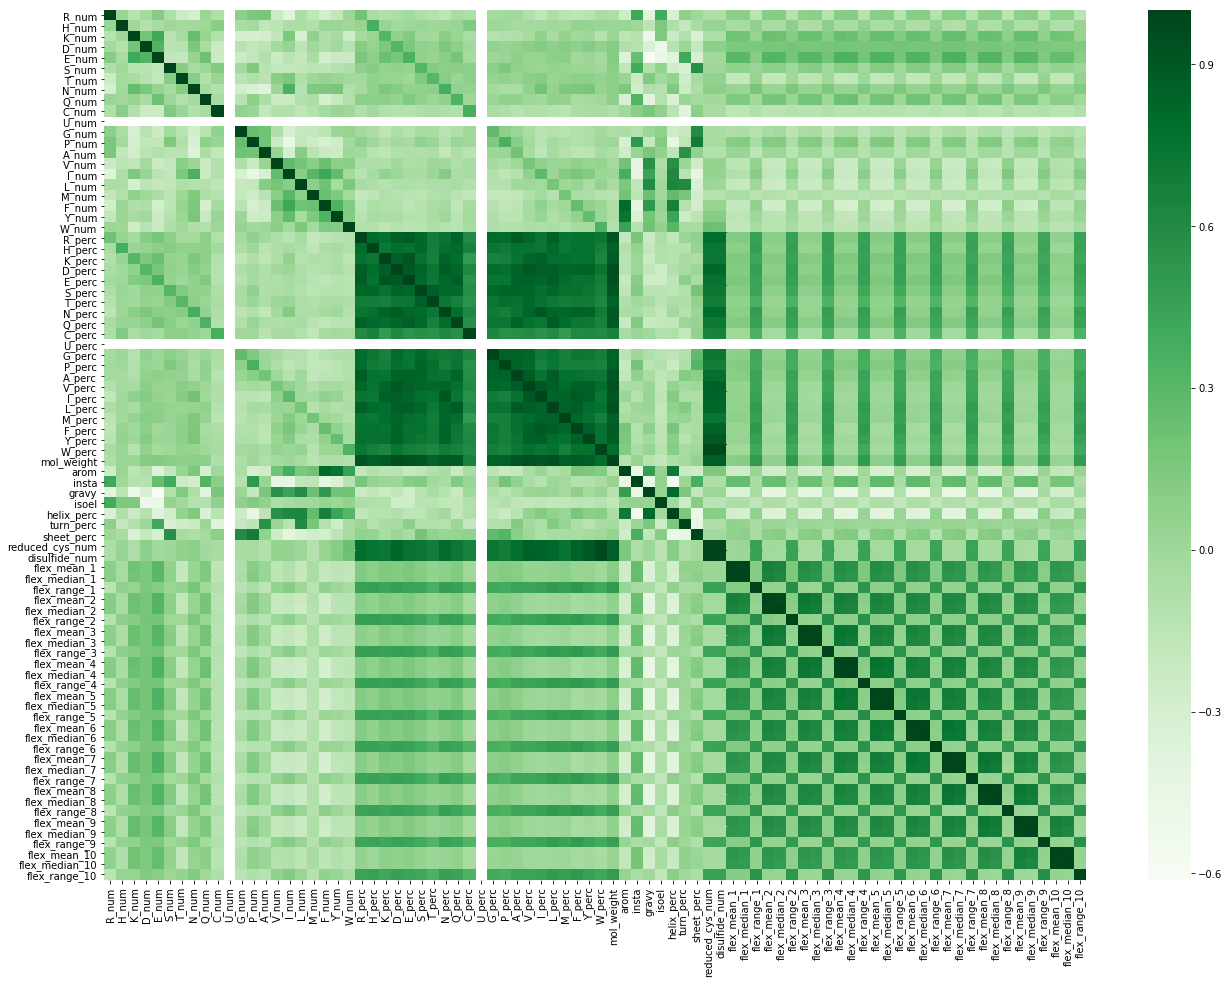

In [310]:
fig, ax = plt.subplots(figsize=(22,16))
sns.heatmap(seq_feat_corr,ax=ax, cmap="Greens")

In [311]:
fig.savefig('seq_features.png',dpi=200)

In [323]:
seq_feat_corr_stacked = seq_feat_corr.stack().drop_duplicates()
rank_corrs = seq_feat_corr_stacked[(seq_feat_corr_stacked != 1) & (seq_feat_corr_stacked >= 0.95)].sort_values(ascending=False).reset_index()
rank_corrs.columns = ['col1','col2','corr']
rank_corrs

,col1,col2,corr
0,reduced_cys_num,disulfide_num,0.999920
1,flex_mean_1,flex_median_1,0.987789
2,flex_mean_4,flex_median_4,0.987738
3,flex_mean_5,flex_median_5,0.987361
4,flex_mean_2,flex_median_2,0.987106
5,flex_mean_3,flex_median_3,0.986991
6,flex_mean_7,flex_median_7,0.986942
7,flex_mean_6,flex_median_6,0.986827
8,flex_mean_8,flex_median_8,0.986715
9,flex_mean_9,flex_median_9,0.986626


In [324]:
drop_cols = rank_corrs['col2'].values.tolist()
drop_cols

['disulfide_num',
 'flex_median_1',
 'flex_median_4',
 'flex_median_5',
 'flex_median_2',
 'flex_median_3',
 'flex_median_7',
 'flex_median_6',
 'flex_median_8',
 'flex_median_9',
 'flex_median_10',
 'reduced_cys_num',
 'disulfide_num']

In [327]:
sequence_feat_flex_df_save = sequence_feat_flex_df.drop(drop_cols,axis=1)
print(sequence_feat_flex_df_save.shape)
sequence_feat_flex_df_save.head()

(20463, 70)


,R_num,H_num,K_num,D_num,E_num,S_num,T_num,N_num,Q_num,C_num,...,flex_mean_6,flex_range_6,flex_mean_7,flex_range_7,flex_mean_8,flex_range_8,flex_mean_9,flex_range_9,flex_mean_10,flex_range_10
protein,,,,,,,,,,,,,,,,,,,,,
RL37A_HUMAN,0.076087,0.021739,0.163043,0.010870,0.021739,0.065217,0.097826,0.010870,0.021739,0.043478,...,0.970070,0.056417,0.989251,0.062321,0.987525,0.040536,0.998399,0.045560,1.032863,0.016655
PYRG1_HUMAN,0.055838,0.030457,0.060914,0.057530,0.076142,0.069374,0.043993,0.028765,0.042301,0.020305,...,1.002592,0.093726,0.991874,0.100060,1.007784,0.086429,1.003565,0.111845,1.007482,0.102762
RL6_HUMAN,0.076389,0.027778,0.180556,0.031250,0.045139,0.048611,0.055556,0.020833,0.031250,0.003472,...,0.984180,0.073798,0.986485,0.075167,1.019604,0.084369,1.027100,0.083238,0.991721,0.091595
RAB10_HUMAN,0.045000,0.015000,0.105000,0.070000,0.065000,0.055000,0.075000,0.050000,0.020000,0.020000,...,1.011560,0.073774,1.024263,0.085345,1.000924,0.083452,1.022086,0.098810,1.011547,0.061810
RAB30_HUMAN,0.059113,0.000000,0.049261,0.044335,0.093596,0.073892,0.059113,0.054187,0.049261,0.029557,...,0.999652,0.084238,1.023271,0.062095,1.014127,0.086548,0.993532,0.079179,1.010060,0.117869


In [328]:
conn = sqlite3.connect("protein_training.db")
sequence_feat_flex_df_save.to_sql('protein_seq_features',con=conn, if_exists='replace')
conn.close()